Выполнил: Кузьмин Андрей, tg: @thisismoto

# ДЗ№1

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections

## Дизайн теста бутстреп

In [ ]:
import requests

# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download: 100%|███████████████████████████████████████████████▉| 78.6M/78.8M [00:02<00:00, 27.3MiB/s]

In [ ]:
# Распаковываем архив из 3 файлов
import zipfile

with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

## 📺 Данные: датасет КИОН
- **просмотры** фильмов и сериалов в приложении KION
- данные о пользователях
- данные об айтемах (фильмы, сериалы и т.д.)

In [ ]:
interactions = pd.read_csv('data_kion/interactions_df.csv')

In [ ]:
interactions.head(5)

# user_id - уникальный идентификатор пользователя
# item_id - уникальный идентификатор контента
# last_watch_dt - последняя дата просмотра юзером определенного контента
# total_dur - суммарная продолжительность просмотра определенного контента юзером (в секундах)
# watched_pct - процент просмотренного контента от общей продолжительности

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [ ]:
interactions.shape

(5476251, 5)

In [ ]:
# предобработка данных
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


In [ ]:
# Оценим сколько у нас пользователей за 1 и 2 недели

In [ ]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()
print(min_date, max_date)

2021-03-13 2021-08-22


In [ ]:
interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=7)]['user_id'].nunique()

185907

In [ ]:
interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]['user_id'].nunique()

279129

### Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)



In [ ]:
# выделим данные за две (последние) недели
week = interactions[interactions['last_watch_dt'] > max_date - datetime.timedelta(days=14)]
print('Уникальных дней', week['last_watch_dt'].nunique(), week['last_watch_dt'].min(), week['last_watch_dt'].max())
week = week.groupby('user_id', as_index=False).agg({'total_dur': sum})

Уникальных дней 14 2021-08-09 2021-08-22


/var/folders/13/53mlvb2s3775f99qt2chfjl80000gn/T/ipykernel_33847/470313147.py:4: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  week = week.groupby('user_id', as_index=False).agg({'total_dur': sum})


In [ ]:
print(week.shape)
week = week[(week['total_dur'] < week['total_dur'].std() * 3)]
print(week.shape)

(266081, 2)
(262794, 2)


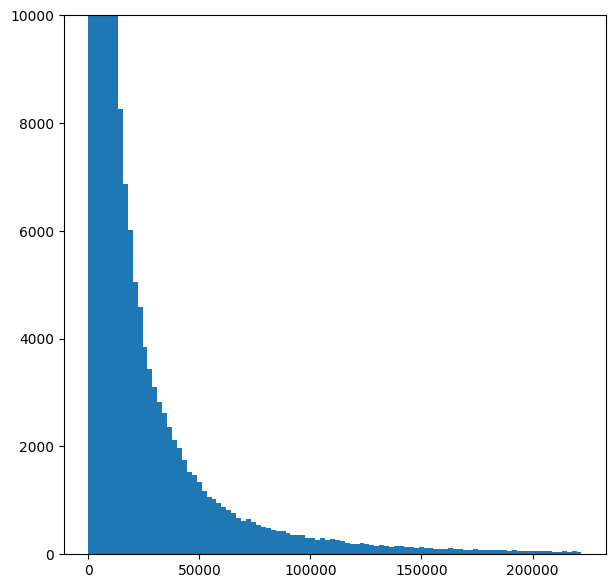

In [ ]:
week['total_dur'].hist(bins=100, figsize=(7,7))
plt.ylim([0, 10000])
plt.grid(False)

In [ ]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

# Делим на 2 равные группы
def groups_splitter(df, columns, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

from scipy.stats import norm

def get_mde(metric_vec, alpha=0.05, beta=0.2):

    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()

    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)

    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)

    return mde*100/metric_mean

## 1. Бутстреп + метрика длительности просмотров

### Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (2 балла)

Моделируем AA-test: прогоняем бутстрап критерий, не добавляя эффект к группе В. Хотим, чтобы критерий НЕ нашел различий в выборках. Если точнее, то нашел не более чем  $\alpha$ случаях.

In [ ]:
from joblib import Parallel, delayed
import numpy as np
import collections
from tqdm import tqdm

# Обернем код в функцию для параллельных вычислений
def process_iteration(week, salt_generator, calc_bootstrap_mean):
    new_df = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    # bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    value_diff = sample_a_mean - sample_b_mean

    left_side, right_side = np.percentile(value_diff, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
    is_correct = not left_side <= 0 <= right_side

    return value_diff, is_correct

# Параллельное выполнение
num_iterations = 1000
results = Parallel(n_jobs=-1)(delayed(process_iteration)(week, salt_generator, calc_bootstrap_mean) for _ in tqdm(range(num_iterations)))

# Распаковка результатов
values, correctness = zip(*results)
values = list(values)
correctness = list(correctness)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:04<04:36,  3.55it/s]

▊                                                                         | 24/1000 [00:08<06:16,  2.59it/s]

█▍                                                                        | 32/1000 [00:14<08:28,  1.90it/s]

██                                                                        | 40/1000 [00:20<09:43,  1.65it/s]

██▌                                                                       | 48/1000 [00:27<10:43,  1.48it/s]

███▏                                                                      | 56/1000 [00:31<09:59,  1.57it/s]

███▊                                                                      | 64/1000 [00:38<10:42,  1.46it/s]

████▍                                                                     | 72/1000 [00:43<10:44,  1.44it/s]

█████   

In [ ]:
# Подсчет количества корректных результатов
test_correctness = collections.Counter(correctness)
significance_boost = round(test_correctness[True] / (test_correctness[True] + test_correctness[False]) * 100, 2)

print(f'Корректность: {significance_boost}%')

Корректность: 5.0%


In [ ]:
print(f'На 1 неделе при 50 итерациях корректность составила 2%. На 2 неделях при 1000 итерациях корректность увеличилась до {significance_boost}%. Увеличение корректности с 2% до {significance_boost}% при переходе с 1 недели на 2 недели связано с тем, что при большем объёме данных и большем количестве итераций бутстрэпа мы получаем более точную оценку. На 1 неделе с малым числом итераций (50) мы получили заниженную оценку из-за высокой вариативности. На 2 неделях и с большим числом итераций (1000) оценка стала ближе к ожидаемым 5%, что говорит о более точном и надежном результате.')

На 1 неделе при 50 итерациях уровень корректность составила 2%. На 2 неделях при 1000 итерациях корректность увеличилась до 5.0%. Увеличение корректности с 2% до 5.0% при переходе с 1 недели на 2 недели связано с тем, что при большем объёме данных и большем количестве итераций бутстрэпа мы получаем более точную оценку. На 1 неделе с малым числом итераций (50) мы получили заниженную оценку из-за высокой вариативности. На 2 неделях и с большим числом итераций (1000) оценка стала ближе к ожидаемым 5%, что говорит о более точном и надежном результате.


In [ ]:
p_values = [get_p_value(dist) for dist in values]

Text(0.5, 1.0, 'Бутстреп распределение p_value')

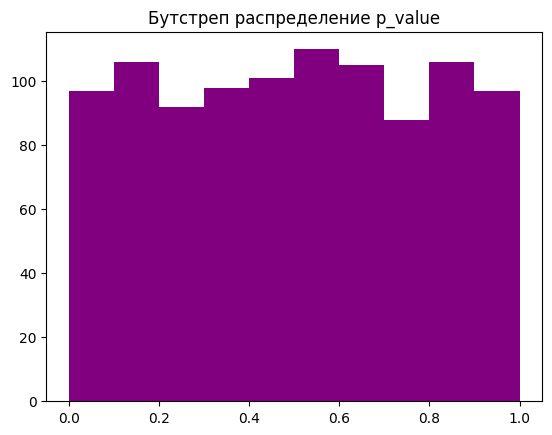

In [ ]:
plt.hist(p_values, bins=10, color='purple');
plt.title(f"Бутстреп распределение p_value")

In [ ]:
stat, p_value_boost_dist = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value_boost_dist < 0.05:
    print(f'p_value = {p_value_boost_dist} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_boost_dist} - p_values равномерное распределение')

p_value = 0.8108971656895569 - p_values равномерное распределение


### На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (3 балла за расчет + 2 балла за подроброе объяснение)


Эффект 1%

In [ ]:
def process_iteration(week, salt_generator, calc_bootstrap_mean):
    new_df = groups_splitter(week, columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[new_df['group'] == 'A']['total_dur'].values
    vec_b = new_df[new_df['group'] == 'B']['total_dur'].values * (1 + 0.01)  # добавляем эффект в 1%

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)  # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    value_diff = sample_a_mean - sample_b_mean

    left_side, right_side = np.percentile(value_diff, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    is_correct = not left_side <= 0 <= right_side

    return value_diff, is_correct

num_iterations = 1000
results = Parallel(n_jobs=-1)(delayed(process_iteration)(week, salt_generator, calc_bootstrap_mean) for _ in tqdm(range(num_iterations)))

values, power = zip(*results)
values = list(values)
power = list(power)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:04<04:14,  3.86it/s]

▊                                                                         | 24/1000 [00:10<07:41,  2.11it/s]

▉                                                                         | 25/1000 [00:10<07:19,  2.22it/s]

█▍                                                                        | 32/1000 [00:16<09:48,  1.64it/s]

██                                                                        | 40/1000 [00:22<10:38,  1.50it/s]

██▌                                                                       | 48/1000 [00:28<11:29,  1.38it/s]

███▏                                                                      | 56/1000 [00:34<11:03,  1.42it/s]

███▊                                                                      | 64/1000 [00:40<11:06,  1.40it/s]

████▍   

In [ ]:
test_power = collections.Counter(power)
power_boost_1_per = round(test_power[True] / (test_power[True] + test_power[False]) * 100, 2)

print(f'Мощность: {power_boost_1_per}%')

Мощность: 30.8%


Эффект 3%

In [ ]:
def process_iteration(week, salt_generator, calc_bootstrap_mean):
    new_df = groups_splitter(week, columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[new_df['group'] == 'A']['total_dur'].values
    vec_b = new_df[new_df['group'] == 'B']['total_dur'].values * (1 + 0.03)  # добавляем эффект в 3%

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)  # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    value_diff = sample_a_mean - sample_b_mean

    left_side, right_side = np.percentile(value_diff, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    is_correct = not left_side <= 0 <= right_side

    return value_diff, is_correct

num_iterations = 1000
results = Parallel(n_jobs=-1)(delayed(process_iteration)(week, salt_generator, calc_bootstrap_mean) for _ in tqdm(range(num_iterations)))

values, power = zip(*results)
values = list(values)
power = list(power)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:04<04:07,  3.98it/s]

▊                                                                         | 24/1000 [00:09<07:10,  2.27it/s]

█▍                                                                        | 32/1000 [00:13<07:21,  2.19it/s]

██                                                                        | 40/1000 [00:17<07:27,  2.15it/s]

██▌                                                                       | 48/1000 [00:23<08:39,  1.83it/s]

███▏                                                                      | 56/1000 [00:28<09:26,  1.67it/s]

███▊                                                                      | 64/1000 [00:34<10:00,  1.56it/s]

████▍                                                                     | 72/1000 [00:40<10:12,  1.52it/s]

█████   

In [ ]:
test_power = collections.Counter(power)
power_boost_3_per = round(test_power[True] / (test_power[True] + test_power[False]) * 100, 2)

print(f'Мощность: {power_boost_3_per}%')

Мощность: 99.3%


Эффект 5%

In [ ]:
def process_iteration(week, salt_generator, calc_bootstrap_mean):
    new_df = groups_splitter(week, columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[new_df['group'] == 'A']['total_dur'].values
    vec_b = new_df[new_df['group'] == 'B']['total_dur'].values * (1 + 0.05)  # добавляем эффект в 5%

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)  # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    value_diff = sample_a_mean - sample_b_mean

    left_side, right_side = np.percentile(value_diff, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    is_correct = not left_side <= 0 <= right_side

    return value_diff, is_correct

num_iterations = 1000
results = Parallel(n_jobs=-1)(delayed(process_iteration)(week, salt_generator, calc_bootstrap_mean) for _ in tqdm(range(num_iterations)))

values, power = zip(*results)
values = list(values)
power = list(power)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:04<04:24,  3.73it/s]

▊                                                                         | 24/1000 [00:09<07:16,  2.24it/s]

█▍                                                                        | 32/1000 [00:15<08:44,  1.85it/s]

██                                                                        | 40/1000 [00:19<08:34,  1.87it/s]

██▌                                                                       | 48/1000 [00:25<09:15,  1.71it/s]

███▏                                                                      | 56/1000 [00:31<10:02,  1.57it/s]

███▊                                                                      | 64/1000 [00:37<10:30,  1.48it/s]

████▍                                                                     | 72/1000 [00:42<10:40,  1.45it/s]

█████   

In [ ]:
test_power = collections.Counter(power)
power_boost_5_per = round(test_power[True] / (test_power[True] + test_power[False]) * 100, 2)

print(f'Мощность: {power_boost_5_per}%')

Мощность: 100.0%


#### Вывод

In [ ]:
print(f'Вывод: Размер эффекта существенно влияет на мощность статистического теста. При небольшом эффекте в 1% мощность теста оказалась низкой ({power_boost_1_per}%), что означает низкую вероятность обнаружения такого эффекта при заданных условиях. С увеличением эффекта до 3% и 5% мощность теста значительно возросла до {power_boost_3_per}% и {power_boost_5_per}% соответственно, показывая высокую вероятность обнаружения более крупных эффектов. Это показывает, что для надёжного выявления малых эффектов требуется увеличивать размер выборки или длительность эксперимента. То есть наблюдается следующая зависимость - увеличение размера эффекта повышает мощность теста.')

Вывод: Размер эффекта существенно влияет на мощность статистического теста. При небольшом эффекте в 1% мощность теста оказалась низкой (30.8%), что означает низкую вероятность обнаружения такого эффекта при заданных условиях. С увеличением эффекта до 3% и 5% мощность теста значительно возросла до 99.3% и 100.0% соответственно, показывая высокую вероятность обнаружения более крупных эффектов. Это показывает, что для надёжного выявления малых эффектов требуется увеличивать размер выборки или длительность эксперимента. То есть наблюдается следующая зависимость - увеличение размера эффекта повышает мощность теста.


## 2. Бутстреп + логарифмированная метрика длительности просмотров

In [ ]:
week['total_dur_ln'] = np.log2(week['total_dur'])

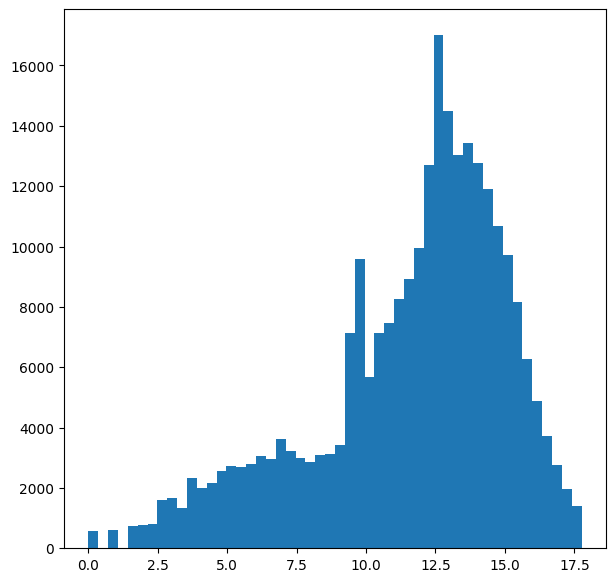

In [ ]:
week['total_dur_ln'].hist(bins=50, figsize=(7,7))
plt.grid(False)

### Корректность

Моделируем AA-test: прогоняем бутстрап критерий, не добавляя эффект к группе В. Хотим, чтобы критерий НЕ нашел различий в выборках. Если точнее, то нашел не более чем  $\alpha$ случаях.

In [ ]:
from joblib import Parallel, delayed
import numpy as np
import collections
from tqdm import tqdm

# Обернем код в функцию для параллельных вычислений
def process_iteration(week, salt_generator, calc_bootstrap_mean):
    new_df = groups_splitter(week.copy(), columns=['user_id', 'total_dur_ln', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['total_dur_ln']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur_ln']

    # bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    value_diff = sample_a_mean - sample_b_mean

    left_side, right_side = np.percentile(value_diff, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
    is_correct = not left_side <= 0 <= right_side

    return value_diff, is_correct

# Параллельное выполнение
num_iterations = 1000
results = Parallel(n_jobs=-1)(delayed(process_iteration)(week, salt_generator, calc_bootstrap_mean) for _ in tqdm(range(num_iterations)))

# Распаковка результатов
values, correctness = zip(*results)
values = list(values)
correctness = list(correctness)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:04<04:09,  3.94it/s]

▊                                                                         | 24/1000 [00:09<07:06,  2.29it/s]

█▍                                                                        | 32/1000 [00:15<08:39,  1.86it/s]

██                                                                        | 40/1000 [00:19<08:16,  1.93it/s]

██▌                                                                       | 48/1000 [00:24<09:09,  1.73it/s]

███▏                                                                      | 56/1000 [00:30<09:45,  1.61it/s]

███▊                                                                      | 64/1000 [00:34<08:52,  1.76it/s]

████▍                                                                     | 72/1000 [00:38<08:56,  1.73it/s]

█████   

In [ ]:
# Подсчет количества корректных результатов
test_correctness = collections.Counter(correctness)
significance_boost_log = round(test_correctness[True] / (test_correctness[True] + test_correctness[False]) * 100, 2)

print(f'Корректность: {significance_boost_log}%')

Корректность: 5.7%


In [ ]:
p_values = [get_p_value(dist) for dist in values]

Text(0.5, 1.0, 'Бутстреп распределение p_value')

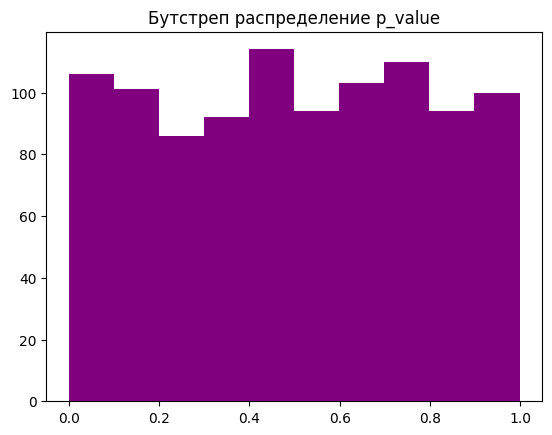

In [ ]:
plt.hist(p_values, bins=10, color='purple');
plt.title(f"Бутстреп распределение p_value")

In [ ]:
stat, p_value_boost_log_dist = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value_boost_log_dist < 0.05:
    print(f'p_value = {p_value_boost_log_dist} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_boost_log_dist} - p_values равномерное распределение')

p_value = 0.9755797627712833 - p_values равномерное распределение


### На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (3 балла за расчет + 2 балла за подроброе объяснение)


Эффект 1%

In [ ]:
def process_iteration(week, salt_generator, calc_bootstrap_mean):
    new_df = groups_splitter(week, columns=['user_id', 'total_dur_ln', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[new_df['group'] == 'A']['total_dur_ln'].values
    vec_b = new_df[new_df['group'] == 'B']['total_dur_ln'].values + np.log2(1 + 0.01)   # добавляем эффект в 1%

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)  # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    value_diff = sample_a_mean - sample_b_mean

    left_side, right_side = np.percentile(value_diff, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    is_correct = not left_side <= 0 <= right_side

    return value_diff, is_correct

num_iterations = 1000
results = Parallel(n_jobs=-1)(delayed(process_iteration)(week, salt_generator, calc_bootstrap_mean) for _ in tqdm(range(num_iterations)))

values, power = zip(*results)
values = list(values)
power = list(power)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:04<04:12,  3.90it/s]

▎                                                                         | 17/1000 [00:04<04:00,  4.09it/s]

▊                                                                         | 24/1000 [00:09<07:33,  2.15it/s]

█▍                                                                        | 32/1000 [00:14<09:07,  1.77it/s]

██                                                                        | 40/1000 [00:19<08:50,  1.81it/s]

██▌                                                                       | 48/1000 [00:24<09:34,  1.66it/s]

███▏                                                                      | 56/1000 [00:30<09:59,  1.57it/s]

███▊                                                                      | 64/1000 [00:35<10:11,  1.53it/s]

████▍   

In [ ]:
test_power = collections.Counter(power)
power_boost_log_1_per = round(test_power[True] / (test_power[True] + test_power[False]) * 100, 2)

print(f'Мощность: {power_boost_log_1_per}%')

Мощность: 18.9%


Эффект 3%

In [ ]:
def process_iteration(week, salt_generator, calc_bootstrap_mean):
    new_df = groups_splitter(week, columns=['user_id', 'total_dur_ln', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[new_df['group'] == 'A']['total_dur_ln'].values
    vec_b = new_df[new_df['group'] == 'B']['total_dur_ln'].values + np.log2(1 + 0.03)  # добавляем эффект в 3%

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)  # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    value_diff = sample_a_mean - sample_b_mean

    left_side, right_side = np.percentile(value_diff, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    is_correct = not left_side <= 0 <= right_side

    return value_diff, is_correct

num_iterations = 1000
results = Parallel(n_jobs=-1)(delayed(process_iteration)(week, salt_generator, calc_bootstrap_mean) for _ in tqdm(range(num_iterations)))

values, power = zip(*results)
values = list(values)
power = list(power)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:05<05:59,  2.73it/s]

▊                                                                         | 24/1000 [00:09<06:38,  2.45it/s]

█▍                                                                        | 32/1000 [00:15<08:22,  1.92it/s]

██                                                                        | 40/1000 [00:19<08:19,  1.92it/s]

██▌                                                                       | 48/1000 [00:25<09:12,  1.72it/s]

███▏                                                                      | 56/1000 [00:28<08:37,  1.82it/s]

███▊                                                                      | 64/1000 [00:34<09:19,  1.67it/s]

████▍                                                                     | 72/1000 [00:40<09:46,  1.58it/s]

█████   

In [ ]:
test_power = collections.Counter(power)
power_boost_log_3_per = round(test_power[True] / (test_power[True] + test_power[False]) * 100, 2)

print(f'Мощность: {power_boost_log_3_per}%')

Мощность: 89.2%


Эффект 5%

In [ ]:
def process_iteration(week, salt_generator, calc_bootstrap_mean):
    new_df = groups_splitter(week, columns=['user_id', 'total_dur_ln', 'group'], user_salt=salt_generator()).drop_duplicates()

    vec_a = new_df[new_df['group'] == 'A']['total_dur_ln'].values
    vec_b = new_df[new_df['group'] == 'B']['total_dur_ln'].values + np.log2(1 + 0.05)  # добавляем эффект в 5%

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)  # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    value_diff = sample_a_mean - sample_b_mean

    left_side, right_side = np.percentile(value_diff, [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    is_correct = not left_side <= 0 <= right_side

    return value_diff, is_correct

num_iterations = 1000
results = Parallel(n_jobs=-1)(delayed(process_iteration)(week, salt_generator, calc_bootstrap_mean) for _ in tqdm(range(num_iterations)))

values, power = zip(*results)
values = list(values)
power = list(power)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:03<03:48,  4.31it/s]

▊                                                                         | 24/1000 [00:08<05:53,  2.76it/s]

█▍                                                                        | 32/1000 [00:13<07:28,  2.16it/s]

██                                                                        | 40/1000 [00:18<08:33,  1.87it/s]

██▌                                                                       | 48/1000 [00:24<09:28,  1.67it/s]

███▏                                                                      | 56/1000 [00:28<09:17,  1.69it/s]

███▊                                                                      | 64/1000 [00:34<09:43,  1.60it/s]

████▍                                                                     | 72/1000 [00:38<08:52,  1.74it/s]

█████   

In [ ]:
test_power = collections.Counter(power)
power_boost_log_5_per = round(test_power[True] / (test_power[True] + test_power[False]) * 100, 2)

print(f'Мощность: {power_boost_log_5_per}%')

Мощность: 99.9%


## Манна-уитни + метрика длительности просмотров (4 балла)

In [ ]:
week1_group = groups_splitter(week, columns=['user_id', 'total_dur', 'group'], user_salt='20241204')
week1_group.head()

,user_id,total_dur,group
0,1,21172,A
1,1000,10744,A
2,1000000,32990,B
3,1000001,52,A
4,1000003,625,B


In [ ]:
week.groupby(by='group', as_index=False).count()

,group,user_id,total_dur,total_dur_ln,hash
0,A,131384,131384,131384,131384
1,B,131410,131410,131410,131410


In [ ]:
from scipy.stats import mannwhitneyu

# проверим, как работает код критерия
u, p = mannwhitneyu(week[week['group'] == 'A']['total_dur'].values,
                    week[week['group'] == 'B']['total_dur'].values)

print(f"p_value = {p}")

p_value = 0.20640244766835758


### Корректность

Проверка распределения p_value - должно быть равномерное

In [ ]:
# Функция для одной итерации
def process_iteration(i):
    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'])

    u_stat, p_value = mannwhitneyu(
        week1_hash[week1_hash['group'] == 'A']['total_dur'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur'].values
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:03<03:30,  4.67it/s]

/Users/andrejkuzmin/myenv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


█▍                                                                        | 32/1000 [00:06<03:22,  4.77it/s]

██                                                                        | 40/1000 [00:07<02:38,  6.04it/s]

██▌                                                                       | 48/1000 [00:08<02:30,  6.31it/s]

███▏                                                                      | 56/1000 [00:09<02:19,  6.75it/s]

███▊                                                                     

In [ ]:
significance_mannwhit = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Корректность = {significance_mannwhit}")

Корректность = 4.9


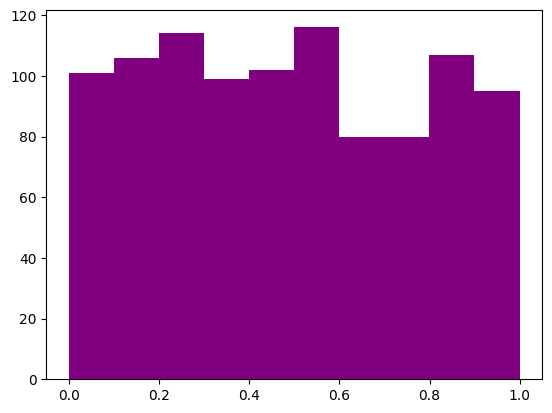

In [ ]:
plt.hist(pvalues, bins=10, color='purple');

<details>
  <summary>📝 Подсказка </summary>
Ой. Кажется критерий Манна-Уитни не подходит. А почему так произошло?
    </details>

<details>
  <summary>📝 Подсказка </summary>
Давайте еще проверим критерием Колмогорова-Смирнова (о том, что получившееся распределение pvalues есть равномерное распределение).
    </details>

In [ ]:
import scipy.stats

stat, p_value_mannwhit_dist = scipy.stats.kstest(pvalues, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value_mannwhit_dist < 0.05:
    print(f'p_value = {p_value_mannwhit_dist} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_mannwhit_dist} - p_values равномерное распределение')

p_value = 0.060516824598998764 - p_values равномерное распределение


<details>
  <summary>📝 Подсказка </summary>
Посмотрим количество уникальных значений в выборке
</details>

In [ ]:
print(f"% уник. значений группы А = {round(week[week['group'] == 'A']['total_dur'].nunique() / week[week['group'] == 'A'].shape[0] * 100, 2)}")
print(f"% уник. значений группы B = {round(week[week['group'] == 'B']['total_dur'].nunique() / week[week['group'] == 'B'].shape[0] * 100, 2)}")

% уник. значений группы А = 31.67
% уник. значений группы B = 31.57


### Докидываем эффект

Эффект 1%

In [ ]:
# Функция для одной итерации
def process_iteration(i):
    # Если необходимо контролировать случайность
    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'])

    u_stat, p_value = mannwhitneyu(
        week1_hash[week1_hash['group'] == 'A']['total_dur'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur'].values * (1 + 0.01)
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:00<00:29, 33.24it/s]

▊                                                                         | 24/1000 [00:01<01:02, 15.59it/s]

█▍                                                                        | 32/1000 [00:02<01:21, 11.89it/s]

██                                                                        | 40/1000 [00:03<01:30, 10.61it/s]

██▌                                                                       | 48/1000 [00:04<01:36,  9.83it/s]

███▏                                                                      | 56/1000 [00:05<01:42,  9.21it/s]

███▊                                                                      | 64/1000 [00:06<01:43,  9.05it/s]

████▍                                                                     | 72/1000 [00:06<01:44,  8.89it/s]

█████   

In [ ]:
power_mannwhit_1_per = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Мощность = {power_mannwhit_1_per}")

Мощность = 24.0


Эффект 3%

In [ ]:
# Функция для одной итерации
def process_iteration(i):
    # Если необходимо контролировать случайность
    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'])

    u_stat, p_value = mannwhitneyu(
        week1_hash[week1_hash['group'] == 'A']['total_dur'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur'].values * (1 + 0.03)
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:00<00:33, 29.63it/s]

▊                                                                         | 24/1000 [00:01<01:08, 14.27it/s]

█▍                                                                        | 32/1000 [00:02<01:25, 11.27it/s]

██                                                                        | 40/1000 [00:03<01:37,  9.88it/s]

██▌                                                                       | 48/1000 [00:04<01:42,  9.27it/s]

███▏                                                                      | 56/1000 [00:05<01:44,  8.99it/s]

███▊                                                                      | 64/1000 [00:06<01:46,  8.79it/s]

████▍                                                                     | 72/1000 [00:07<01:46,  8.70it/s]

█████   

In [ ]:
power_mannwhit_3_per = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Мощность = {power_mannwhit_3_per}")

Мощность = 95.6


Эффект 5%

In [ ]:
# Функция для одной итерации
def process_iteration(i):
    # Если необходимо контролировать случайность
    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'])

    u_stat, p_value = mannwhitneyu(
        week1_hash[week1_hash['group'] == 'A']['total_dur'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur'].values * (1 + 0.05)
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:00<00:31, 31.25it/s]

▊                                                                         | 24/1000 [00:01<01:03, 15.38it/s]

█▍                                                                        | 32/1000 [00:02<01:22, 11.71it/s]

██                                                                        | 40/1000 [00:03<01:32, 10.36it/s]

██▌                                                                       | 48/1000 [00:04<01:38,  9.70it/s]

███▏                                                                      | 56/1000 [00:05<01:40,  9.42it/s]

███▊                                                                      | 64/1000 [00:06<01:42,  9.16it/s]

████▍                                                                     | 72/1000 [00:06<01:42,  9.02it/s]

█████   

In [ ]:
power_mannwhit_5_per = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Мощность = {power_mannwhit_5_per}")

Мощность = 100.0


## Mанна-уитни + логарифмированная метрика длительности просмотров (4 балла)

Попробуем что то сделать с этой метрикой

Один из вариантов - логарифмирование метрики, способ снизить дисперсию

In [ ]:
# проверим, как работает код критерия
u, p = mannwhitneyu(week[week['group'] == 'A']['total_dur_ln'].values,
                    week[week['group'] == 'B']['total_dur_ln'].values)

print(f"p_value = {p}")

p_value = 0.20640244766835758


### Корректность

In [ ]:
# Функция для одной итерации
def process_iteration(i):
    # Если необходимо контролировать случайность
    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur_ln', 'group'])

    u_stat, p_value = mannwhitneyu(
        week1_hash[week1_hash['group'] == 'A']['total_dur_ln'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur_ln'].values
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:00<00:30, 32.17it/s]

▊                                                                         | 24/1000 [00:01<01:05, 14.94it/s]

█▍                                                                        | 32/1000 [00:02<01:22, 11.78it/s]

██                                                                        | 40/1000 [00:03<01:32, 10.41it/s]

██▌                                                                       | 48/1000 [00:04<01:36,  9.85it/s]

███▏                                                                      | 56/1000 [00:05<01:42,  9.17it/s]

███▊                                                                      | 64/1000 [00:06<01:44,  8.98it/s]

████▍                                                                     | 72/1000 [00:07<01:42,  9.02it/s]

█████   

In [ ]:
significance_mannwhit_log = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Корректность = {significance_mannwhit_log}")

Корректность = 4.0


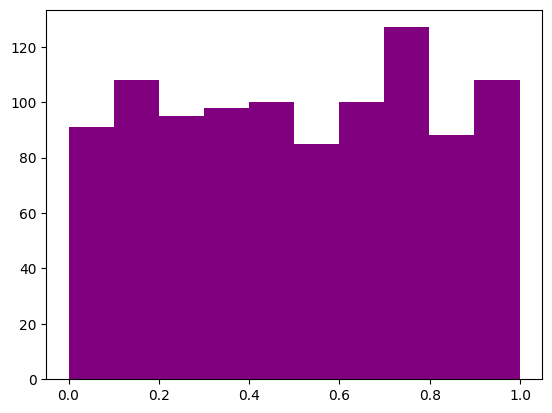

In [ ]:
plt.hist(pvalues, bins=10, color='purple');

In [ ]:
stat, p_value_mannwhit_log_dist = scipy.stats.kstest(pvalues, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value_mannwhit_log_dist < 0.05:
    print(f'p_value = {p_value_mannwhit_log_dist} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_mannwhit_log_dist} - p_values равномерное распределение')

p_value = 0.3475820111118152 - p_values равномерное распределение


### Докидываем эффект

Эффект 1%

In [ ]:
# Функция для одной итерации
def process_iteration(i):
    # Если необходимо контролировать случайность
    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur_ln', 'group'])

    u_stat, p_value = mannwhitneyu(
        week1_hash[week1_hash['group'] == 'A']['total_dur_ln'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur_ln'].values + np.log2(1 + 0.01)
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:01<01:16, 12.84it/s]

▊                                                                         | 24/1000 [00:02<01:55,  8.46it/s]

█▍                                                                        | 32/1000 [00:04<02:26,  6.61it/s]

██                                                                        | 40/1000 [00:05<02:19,  6.88it/s]

██▌                                                                       | 48/1000 [00:07<03:05,  5.13it/s]

███▏                                                                      | 56/1000 [00:08<02:51,  5.50it/s]

███▊                                                                      | 64/1000 [00:09<02:31,  6.16it/s]

████▍                                                                     | 72/1000 [00:10<02:15,  6.84it/s]

█████   

In [ ]:
power_mannwhit_log_1_per = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Мощность = {power_mannwhit_log_1_per}")

Мощность = 25.1


Эффект 3%

In [ ]:
# Функция для одной итерации
def process_iteration(i):
    # Если необходимо контролировать случайность
    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur_ln', 'group'])

    u_stat, p_value = mannwhitneyu(
        week1_hash[week1_hash['group'] == 'A']['total_dur_ln'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur_ln'].values + np.log2(1 + 0.03)
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:00<00:31, 31.01it/s]

▊                                                                         | 24/1000 [00:01<01:04, 15.16it/s]

█▍                                                                        | 32/1000 [00:02<01:22, 11.68it/s]

██                                                                        | 40/1000 [00:03<01:33, 10.27it/s]

██▌                                                                       | 48/1000 [00:04<01:38,  9.71it/s]

███▏                                                                      | 56/1000 [00:05<01:43,  9.14it/s]

███▊                                                                      | 64/1000 [00:06<01:44,  8.98it/s]

████▍                                                                     | 72/1000 [00:07<01:45,  8.77it/s]

█████   

In [ ]:
power_mannwhit_log_3_per = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Мощность = {power_mannwhit_log_3_per}")

Мощность = 96.2


Эффект 5%

In [ ]:
# Функция для одной итерации
def process_iteration(i):
    # Если необходимо контролировать случайность
    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur_ln', 'group'])

    u_stat, p_value = mannwhitneyu(
        week1_hash[week1_hash['group'] == 'A']['total_dur_ln'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur_ln'].values + np.log2(1 + 0.05)
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:00<00:32, 30.11it/s]

▌                                                                         | 20/1000 [00:00<00:30, 31.65it/s]

▊                                                                         | 24/1000 [00:01<01:18, 12.44it/s]

█▍                                                                        | 32/1000 [00:02<01:36, 10.03it/s]

██                                                                        | 40/1000 [00:03<01:47,  8.94it/s]

██▌                                                                       | 48/1000 [00:04<01:53,  8.41it/s]

███▏                                                                      | 56/1000 [00:05<01:57,  8.02it/s]

███▊                                                                      | 64/1000 [00:06<01:58,  7.90it/s]

████▍   

In [ ]:
power_mannwhit_log_5_per = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Мощность = {power_mannwhit_log_5_per}")

Мощность = 100.0


## t-test + метрика длительности просмотров (4 балла)

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
np.var(week[week['group'] == 'A']['total_dur'])

np.float64(785761307.9055578)

In [ ]:
np.var(week[week['group'] == 'B']['total_dur'])

np.float64(764726954.6254065)

In [ ]:
(np.var(week[week['group'] == 'B']['total_dur']) - np.var(week[week['group'] == 'A']['total_dur'])) / np.var(week[week['group'] == 'A']['total_dur']) * 100

np.float64(-2.6769393031349678)

In [ ]:
# проверим, как работает код критерия
u, p = ttest_ind(week[week['group'] == 'A']['total_dur'].values,
                 week[week['group'] == 'B']['total_dur'].values)

print(f"p_value = {p}")

p_value = 0.019487408291341556


### Корректность

In [ ]:
def process_iteration(i):

    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'])

    # Выполнение t-теста
    t_stat, p_value = ttest_ind(
        week1_hash[week1_hash['group'] == 'A']['total_dur'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur'].values,
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:00<00:41, 23.99it/s]

▍                                                                         | 19/1000 [00:00<00:40, 24.20it/s]

▊                                                                         | 24/1000 [00:02<01:49,  8.91it/s]

█▍                                                                        | 32/1000 [00:02<01:38,  9.87it/s]

██                                                                        | 40/1000 [00:03<01:41,  9.46it/s]

██▌                                                                       | 48/1000 [00:05<02:16,  7.00it/s]

███▏                                                                      | 56/1000 [00:06<02:13,  7.10it/s]

███▊                                                                      | 64/1000 [00:08<03:01,  5.17it/s]

████▍   

In [ ]:
significance_ttest = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Корректность = {significance_ttest}")

Корректность = 5.4


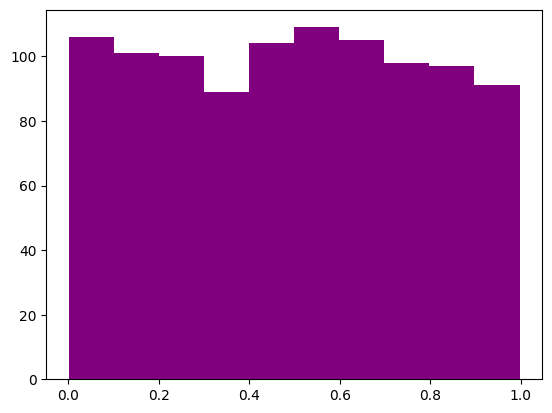

In [ ]:
plt.hist(pvalues, bins=10, color='purple');

In [ ]:
stat, p_value_ttest_dist = scipy.stats.kstest(pvalues, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value_ttest_dist < 0.05:
    print(f'p_value = {p_value_ttest_dist} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_ttest_dist} - p_values равномерное распределение')

p_value = 0.6259226399972706 - p_values равномерное распределение


### Докидываем эффект

Эффект 1%

In [ ]:
def process_iteration(i):

    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'])

    # Выполнение t-теста
    t_stat, p_value = ttest_ind(
        week1_hash[week1_hash['group'] == 'A']['total_dur'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur'].values * (1 + 0.01),
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:00<00:41, 23.92it/s]

▊                                                                         | 24/1000 [00:01<01:13, 13.31it/s]

█▍                                                                        | 32/1000 [00:05<03:34,  4.51it/s]

██                                                                        | 40/1000 [00:07<03:47,  4.22it/s]

██▌                                                                       | 48/1000 [00:08<03:03,  5.20it/s]

███▏                                                                      | 56/1000 [00:09<02:48,  5.60it/s]

███▊                                                                      | 64/1000 [00:10<02:37,  5.94it/s]

████▍                                                                     | 72/1000 [00:11<02:20,  6.60it/s]

█████   

In [ ]:
power_ttest_1_per = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Мощность = {power_ttest_1_per}")

Мощность = 31.4


Эффект 3%

In [ ]:
def process_iteration(i):

    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'])

    # Выполнение t-теста
    t_stat, p_value = ttest_ind(
        week1_hash[week1_hash['group'] == 'A']['total_dur'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur'].values * (1 + 0.03),
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:00<00:30, 32.13it/s]

▊                                                                         | 24/1000 [00:01<00:59, 16.29it/s]

█▍                                                                        | 32/1000 [00:02<01:19, 12.19it/s]

██                                                                        | 40/1000 [00:03<01:31, 10.54it/s]

██▌                                                                       | 48/1000 [00:04<01:36,  9.91it/s]

███▏                                                                      | 56/1000 [00:05<01:39,  9.46it/s]

███▊                                                                      | 64/1000 [00:05<01:39,  9.39it/s]

████▍                                                                     | 72/1000 [00:06<01:41,  9.11it/s]

█████   

In [ ]:
power_ttest_3_per = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Мощность = {power_ttest_3_per}")

Мощность = 99.7


Эффект 5%

In [ ]:
def process_iteration(i):

    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'])

    # Выполнение t-теста
    t_stat, p_value = ttest_ind(
        week1_hash[week1_hash['group'] == 'A']['total_dur'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur'].values * (1 + 0.05),
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:00<00:30, 32.67it/s]

▊                                                                         | 24/1000 [00:01<01:02, 15.58it/s]

█▍                                                                        | 32/1000 [00:02<01:20, 12.01it/s]

██                                                                        | 40/1000 [00:03<01:29, 10.69it/s]

██▌                                                                       | 48/1000 [00:04<01:35,  9.94it/s]

███▏                                                                      | 56/1000 [00:05<01:39,  9.47it/s]

███▊                                                                      | 64/1000 [00:05<01:40,  9.27it/s]

████▍                                                                     | 72/1000 [00:06<01:42,  9.05it/s]

█████   

In [ ]:
power_ttest_5_per = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Мощность = {power_ttest_5_per}")

Мощность = 100.0


### MDE

Эффект 2.5%

In [ ]:
def process_iteration(i):

    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'])

    # Выполнение t-теста
    t_stat, p_value = ttest_ind(
        week1_hash[week1_hash['group'] == 'A']['total_dur'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur'].values * (1 + 0.025),
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:00<00:40, 24.38it/s]

▊                                                                         | 24/1000 [00:01<01:12, 13.39it/s]

█▍                                                                        | 32/1000 [00:02<01:30, 10.74it/s]

██                                                                        | 40/1000 [00:03<01:42,  9.37it/s]

██▌                                                                       | 48/1000 [00:04<01:52,  8.47it/s]

███▏                                                                      | 56/1000 [00:05<01:55,  8.14it/s]

███▊                                                                      | 64/1000 [00:06<01:57,  7.97it/s]

████▍                                                                     | 72/1000 [00:08<02:09,  7.18it/s]

█████   

In [ ]:
power_ttest_25_per = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Мощность = {power_ttest_25_per}")

Мощность = 95.9


In [ ]:
get_mde(week['total_dur'], alpha=significance_ttest/100, beta=1-power_ttest_25_per/100)

np.float64(1.2568264212517946)

## t-test + логарифмированная метрика длительности просмотров (4 балла)

In [ ]:
# проверим, как работает код критерия
u, p = ttest_ind(week[week['group'] == 'A']['total_dur_ln'].values,
                 week[week['group'] == 'B']['total_dur_ln'].values)

print(f"p_value = {p}")

p_value = 0.18904922388823162


### Корректность

In [ ]:
def process_iteration(i):

    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur_ln', 'group'])

    # Выполнение t-теста
    t_stat, p_value = ttest_ind(
        week1_hash[week1_hash['group'] == 'A']['total_dur_ln'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur_ln'].values
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:00<00:29, 33.70it/s]

▊                                                                         | 24/1000 [00:01<01:02, 15.62it/s]

█▍                                                                        | 32/1000 [00:02<01:19, 12.21it/s]

██                                                                        | 40/1000 [00:03<01:29, 10.75it/s]

██▌                                                                       | 48/1000 [00:04<01:36,  9.87it/s]

███▏                                                                      | 56/1000 [00:05<01:40,  9.44it/s]

███▊                                                                      | 64/1000 [00:05<01:41,  9.18it/s]

████▍                                                                     | 72/1000 [00:06<01:42,  9.09it/s]

█████   

In [ ]:
significance_ttest_log = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Корректность = {significance_ttest_log}")

Корректность = 5.6


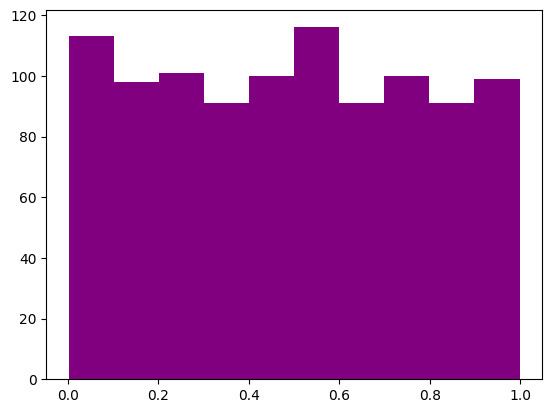

In [ ]:
plt.hist(pvalues, bins=10, color='purple');

In [ ]:
stat, p_value_ttest_log_dist = scipy.stats.kstest(pvalues, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value_ttest_log_dist < 0.05:
    print(f'p_value = {p_value_ttest_log_dist} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value_ttest_log_dist} - p_values равномерное распределение')

p_value = 0.45370413250249664 - p_values равномерное распределение


### Докидываем эффект

Эффект 1%

In [ ]:
def process_iteration(i):

    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur_ln', 'group'])

    # Выполнение t-теста
    t_stat, p_value = ttest_ind(
        week1_hash[week1_hash['group'] == 'A']['total_dur_ln'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur_ln'].values + np.log2(1 + 0.01)
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:00<00:31, 31.47it/s]

▊                                                                         | 24/1000 [00:01<01:03, 15.32it/s]

█▍                                                                        | 32/1000 [00:02<01:21, 11.84it/s]

██                                                                        | 40/1000 [00:03<01:30, 10.60it/s]

██▌                                                                       | 48/1000 [00:04<01:35,  9.99it/s]

███▏                                                                      | 56/1000 [00:05<01:38,  9.56it/s]

███▊                                                                      | 64/1000 [00:05<01:40,  9.34it/s]

████▍                                                                     | 72/1000 [00:06<01:42,  9.10it/s]

█████   

In [ ]:
power_ttest_log_1_per = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Мощность = {power_ttest_log_1_per}")

Мощность = 19.3


Эффект 3%

In [ ]:
def process_iteration(i):

    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur_ln', 'group'])

    # Выполнение t-теста
    t_stat, p_value = ttest_ind(
        week1_hash[week1_hash['group'] == 'A']['total_dur_ln'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur_ln'].values + np.log2(1 + 0.03)
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:00<00:30, 32.46it/s]

▊                                                                         | 24/1000 [00:01<01:02, 15.51it/s]

█▍                                                                        | 32/1000 [00:02<01:21, 11.90it/s]

██                                                                        | 40/1000 [00:03<01:30, 10.62it/s]

██▌                                                                       | 48/1000 [00:04<01:36,  9.91it/s]

███▏                                                                      | 56/1000 [00:05<01:40,  9.41it/s]

███▊                                                                      | 64/1000 [00:06<01:41,  9.18it/s]

████▍                                                                     | 72/1000 [00:06<01:42,  9.03it/s]

█████   

In [ ]:
power_ttest_log_3_per = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Мощность = {power_ttest_log_3_per}")

Мощность = 86.5


Эффект 5%

In [ ]:
def process_iteration(i):

    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur_ln', 'group'])

    # Выполнение t-теста
    t_stat, p_value = ttest_ind(
        week1_hash[week1_hash['group'] == 'A']['total_dur_ln'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur_ln'].values + np.log2(1 + 0.05)
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

▏                                                                         | 16/1000 [00:00<00:29, 32.94it/s]

▊                                                                         | 24/1000 [00:01<01:01, 15.79it/s]

█▍                                                                        | 32/1000 [00:02<01:21, 11.86it/s]

██                                                                        | 40/1000 [00:03<01:32, 10.43it/s]

██▌                                                                       | 48/1000 [00:04<01:36,  9.85it/s]

███▏                                                                      | 56/1000 [00:05<01:39,  9.50it/s]

███▊                                                                      | 64/1000 [00:06<01:40,  9.27it/s]

████▍                                                                     | 72/1000 [00:06<01:42,  9.06it/s]

█████   

In [ ]:
power_ttest_log_5_per = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Мощность = {power_ttest_log_5_per}")

Мощность = 100.0


### MDE

In [ ]:
def process_iteration(i):

    week1_hash = groups_splitter(week.copy(), columns=['user_id', 'total_dur_ln', 'group'])

    # Выполнение t-теста
    t_stat, p_value = ttest_ind(
        week1_hash[week1_hash['group'] == 'A']['total_dur_ln'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur_ln'].values + np.log2(1 + 0.025)
    )
    return p_value

# Параллельное выполнение
num_iterations = 1000
pvalues = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(num_iterations))
)

pvalues = pd.Series(pvalues)



                                                                                   | 0/1000 [00:00<?, ?it/s]

                                                                           | 8/1000 [00:00<00:31, 31.63it/s]

▏                                                                         | 16/1000 [00:01<02:15,  7.27it/s]

▊                                                                         | 24/1000 [00:02<01:51,  8.77it/s]

█▍                                                                        | 32/1000 [00:03<01:59,  8.10it/s]

██                                                                        | 40/1000 [00:04<02:07,  7.51it/s]

██▌                                                                       | 48/1000 [00:06<02:12,  7.19it/s]

███▏                                                                      | 56/1000 [00:07<02:28,  6.36it/s]

███▊                                                                      | 64/1000 [00:08<02:26,  6.39it/s]

████▍   

In [ ]:
power_ttest_log_25_per = round(100 * pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0], 2)

print(f"Мощность = {power_ttest_log_25_per}")

Мощность = 72.8


In [ ]:
get_mde(week['total_dur_ln'], alpha=significance_ttest_log/100, beta=1-power_ttest_log_25_per/100)

np.float64(0.14776928587757834)

## Выводы

Подробно описать выводы для каждой пары, какие варианты точно не подходят и почему. Объяснить зачем мы логарифмируем метрику и что нам это дает. Аргументированно выбрать 1 пару (метрика + критерий) которым вы будете оценивать АБ тест и какой эффект мы сможем отловить в нашем тесте. (5 баллов)

In [ ]:
pd.DataFrame({'Коррекность': [significance_boost, significance_boost_log, significance_mannwhit, significance_mannwhit_log, significance_ttest, significance_ttest_log],
              'Мощность, 1% эфф': [power_boost_1_per, power_boost_log_1_per, power_mannwhit_1_per, power_mannwhit_log_1_per, power_ttest_1_per, power_ttest_log_1_per],
              'Мощность, 3% эфф': [power_boost_3_per, power_boost_log_3_per, power_mannwhit_3_per, power_mannwhit_log_3_per, power_ttest_3_per, power_ttest_log_3_per],
              'Мощность, 5% эфф': [power_boost_5_per, power_boost_log_5_per, power_mannwhit_5_per, power_mannwhit_log_5_per, power_ttest_5_per, power_ttest_log_5_per],
              'K-S распределение': [p_value_boost_dist, p_value_boost_log_dist, p_value_mannwhit_dist, p_value_mannwhit_log_dist, p_value_ttest_dist, p_value_ttest_log_dist]},
              index=['бутстреп + метрика', 'бутстреп + логарифмированная метрика', 'манна-уитни + метрика', 'манна-уитни + логарифмированная метрика', 't-test + метрика', 't-test + логарифмированная метрика']
)

,Коррекность,"Мощность, 1% эфф","Мощность, 3% эфф","Мощность, 5% эфф",K-S распределение
бутстреп + метрика,5.0,30.8,99.3,100.0,0.810897
бутстреп + логарифмированная метрика,5.7,18.9,89.2,99.9,0.975580
манна-уитни + метрика,4.9,24.0,95.6,100.0,0.060517
манна-уитни + логарифмированная метрика,4.0,25.1,96.2,100.0,0.347582
t-test + метрика,5.4,31.4,99.7,100.0,0.625923
t-test + логарифмированная метрика,5.6,19.3,86.5,100.0,0.453704


Логарифмирование метрики применяется для преобразования распределения исходных данных ближе к нормальному. В данных с распределением не похожим на нормальное и наличием выбросов логарифмирование может уменьшить влияние крупных значений и сделать распределение более симметричным. Это важно для методов, чувствительных к нормальности распределения, таких как t-тест.

Для нашей задачи точно не подходит критерий манна-уитни. Так как он плохо работает с данными где мало уникальных значений, у нас в группах примерно 32% уникальных значений. Видно что манна-уитни + логарифмированная метрика имеет более равномерное распределение (0.34) против (0.06) на обычной выборке. На основе условия с малым количеством уникальных значений отсекаем критерий манна-уитни целиком.

t-test в нашем случае подходит cо всеми парами метрик, но имеет малую статистику k-s распределения p_value относительно пар с бустрепом. Также видим что t-test + логарифмированная метрика делает распределение менее нормальным.

Видим что по значению корректности (5%) и мощности при эффекте в 3% (99.3%)(ближайшая к ожидаемой в 2.5%) выигрывает бутстреп +  стандартная метрика, хотя мы видим на бустрепе с логарифмированной метрикой более равномерное распределение чем на стандартной 0.97 против 0.81 соответственно.

По значению корректности, мощности при эффекте в 3% и величине k-s распределения p_value выбираем бутстреп + метрика длительности просмотра.

## A/B тест

## Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (2 балла)

In [ ]:
week_ab = week.copy()

In [ ]:
week_ab['total_dur'] = week_ab['total_dur'].apply(lambda x: x if x >= 500 else 0)

## Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (1 балла)

In [ ]:
week1_hash = groups_splitter(week_ab.copy(), columns=['user_id', 'total_dur', 'group'], user_salt='kiontestmodel20210805')

In [ ]:
week1_hash.head()

,user_id,total_dur,group
0,1,21172,B
1,1000,10744,B
2,1000000,32990,B
3,1000001,0,B
4,1000003,625,A


In [ ]:
week1_hash.groupby(by='group', as_index=False).count()

,group,user_id,total_dur
0,A,131931,131931
1,B,130863,130863


Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (2 балла)

In [ ]:
week1_hash[week1_hash['group'] == 'B']['total_dur'].describe()

count    130863.000000
mean      15831.807524
std       27792.330268
min           0.000000
25%         875.000000
50%        5635.000000
75%       17529.000000
max      221818.000000
Name: total_dur, dtype: float64

In [ ]:
# Фильтруем пользователей группы B
group_b = week1_hash[week1_hash['group'] == 'B']

# Находим порог для топ-10% пользователей по total_dur в группе B
threshold = group_b['total_dur'].quantile(0.9)

# Идентифицируем пользователей группы B, у которых total_dur больше или равно порогу
top_10_percent_users = group_b[group_b['total_dur'] >= threshold]['user_id']

# Увеличиваем total_dur на 2.5% для этих пользователей в исходном DataFrame
week1_hash.loc[week1_hash['user_id'].isin(top_10_percent_users), 'total_dur'] *= 1.025

/var/folders/13/53mlvb2s3775f99qt2chfjl80000gn/T/ipykernel_33847/1219307963.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[73467.9   48980.65  65216.65  ... 81195.375 47994.6   79733.725]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  week1_hash.loc[week1_hash['user_id'].isin(top_10_percent_users), 'total_dur'] *= 1.025


In [ ]:
week1_hash[week1_hash['group'] == 'B']['total_dur'].describe()

count    130863.000000
mean      16041.820277
std       28456.497639
min           0.000000
25%         875.000000
50%        5635.000000
75%       17529.000000
max      227363.450000
Name: total_dur, dtype: float64

## Считаем тест

Посчитайте результат такого теста и сделайте выводы (10 баллов)

Сформулируем нулевую и альтернативную гипотезы:

H₀: Средняя длительность просмотров в группе А = B; <br>
H₁: Средняя длительность просмотров в группе А ≠ B;

In [ ]:
def statistic(data):
    return np.mean(data)


def get_bootstrap(group_A, group_B, iters=100, alpha=0.05):

    bootstrap_statistics = []

    # Generate bootstrap samples
    for _ in range(iters):

        bootstrap_sample_A = np.random.choice(group_A, len(group_A), replace=True)
        bootstrap_sample_B = np.random.choice(group_B, len(group_B), replace=True)

        statistic_A = statistic(bootstrap_sample_A)
        statistic_B = statistic(bootstrap_sample_B)

        bootstrap_statistics.append(statistic_B - statistic_A)

    # Compute the confidence interval (e.g., 95% CI)
    confidence_interval = np.percentile(bootstrap_statistics, [100 * alpha / 2., 100 * (1 - alpha / 2.)])

    return bootstrap_statistics, confidence_interval

def get_p_value(dist):
    dist = np.array(dist)
    # calculate the proportion of values greater than 0
    x = (dist > 0).mean()
    # calculate the two-tailed p-value
    pvalue = min(x, 1 - x) * 2
    return pvalue

In [ ]:
stats, (left_side, right_side) = get_bootstrap(week1_hash[week1_hash['group'] == 'A']['total_dur'],
                                               week1_hash[week1_hash['group'] == 'B']['total_dur'])

In [ ]:
left_side, right_side

(np.float64(26.99618336367753), np.float64(438.05093267407324))

In [ ]:
get_p_value(stats)

np.float64(0.020000000000000018)

In [ ]:
get_p_value(stats) < 0.05

np.True_

Выиграла группа B, так как get_p_value(stats) < 0.05

Нулевая гипотеза Ho отвергвется и принимается H1, о том что группы неодинаковы.